# 数据分析—泰坦尼克之灾

[** @seanlee **](https://github.com/SeanLee97)

目录：
1. 加载数据，分析数据
2. 数据清洗
3. 特征工程
4. 模型预测

## 1. 加载数据，分析数据的组成

In [116]:
import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

In [117]:
df = pd.read_csv('./data/train.csv')
# 输出数据信息
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


可以看到，数据总共有12个属性，分别是
1. 'PassengerId': 乘客编号
2. 'Survived'： 是否存活（1存活，0死亡）
3. 'Pclass'： 客舱等级 （1， 2， 3）
4. 'Name'： 乘客姓名
5. 'Sex'： 乘客性别
6. 'Age'： 乘客年龄 
7. 'SibSp'： 乘客兄弟姐妹/配偶数
8. 'Parch'： 乘客父母/子女数
9. 'Ticket': 船票号
9. 'Fare'： 船票价格
10. 'Cabin'： 舱号
11. 'Embarked'：登陆港口

得到属性后我们关心的是找到和用户存活相关的属性，也就是哪些属性影响Survived属性。

从给出的info表看到，存在数据缺失的情况，如：**Age, Cabin, Embarked**，**往往数据缺失的部分是提高整个模型的准确率的关键**，我们要做的是挖掘出丢失的数据，将其影响加入到结果预测中

### 1.1 先看值的分布

In [118]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


descibe() 给出了总数，均值，标准值等数据，看了头有点晕吧，好吧这里我们只是大概看一下值的范围，最后的数值的规整化才会用到

## 2. 数据的清洗

接下来逐个揭开数据的面纱！

### Survived

让我们先看看存活占比吧

[549 342]


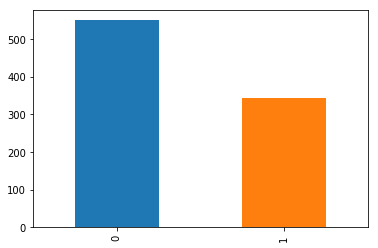

In [119]:
df.Survived.value_counts().plot(kind='bar')
print(df.Survived.value_counts().values)
plt.show()

### PassengerId

乘客编号，一般来说编号是顺序生成的，如果是顺序生成的话，那么数据就没有多大的意义。

但是也有其他情况，比如银行排号，金、银、普卡的编号一般是不一样的，如果是按照这种方式说明PassagerId中包含了不同等级人群(感觉有点用词不当)的含义，所以一般是按区间来处理。到底属于哪种呢？我们先分析分析

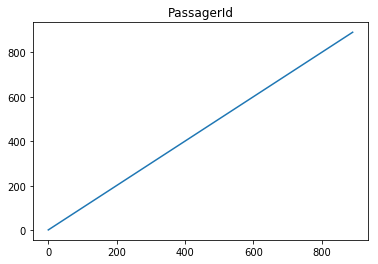

In [120]:
plt.title('PassagerId')
plt.plot(df.PassengerId)
plt.show()

好吧，可以看到编号是顺序生成的，所以，我们先放下这个属性

### Pclass

Pclass是舱位的等级，就好比飞机分头等舱，商务舱，普通。一般来说越高级的舱位提供的安全措施可能会比较到位，所以这应该是一个影响因素，到底是不是呢？让我们分析分析再下定论

3    491
1    216
2    184
Name: Pclass, dtype: int64


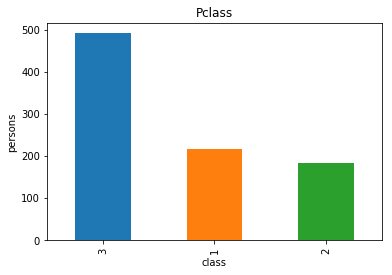

In [121]:
plt.title('Pclass')
plt.xlabel('class')
plt.ylabel('persons')
print(df.Pclass.value_counts())
df.Pclass.value_counts().plot(kind='bar')
plt.show()

上面是各舱位人数分布。现在让我看看各舱位存活人数

alive
[136 119  87]
die
[372  97  80]


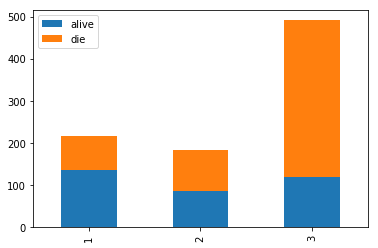

In [122]:
fig = plt.figure()
alive = df.Pclass[df.Survived == 1].value_counts()
die = df.Pclass[df.Survived == 0].value_counts()
print('alive')
print(alive.values)
print('die')
print(die.values)
_df = pd.DataFrame({'alive': alive, 'die': die})
_df.plot(kind='bar', stacked=True)
plt.show()

可以看到3中死亡占比最高，1最少，3应该是普通舱，1应该是贵宾舱，所以舱位等级对存活造成影响

### Cabbin

舱号缺失比较严重， 先分析舱号缺失和不缺失存活占比

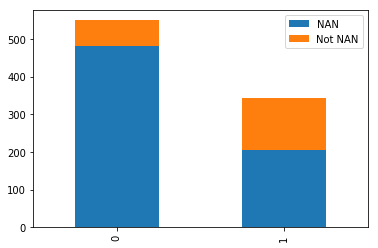

In [123]:
cabin_notnull = df.Survived[pd.notnull(df.Cabin)].value_counts()
cabin_null = df.Survived[pd.isnull(df.Cabin)].value_counts()

_df = pd.DataFrame({'Not NAN': cabin_notnull, 'NAN': cabin_null})
_df.plot(kind='bar', stacked=True)
plt.show()

可以看到死亡的乘客中丢失舱号的占大多数，从直观上可以认为舱号数据是否丢失与存活有关联，但由于舱号大部分缺失，未知性太多，一些内部的关系不能得到确定，所以这个属性还得需要挖掘。

### Fare

船票价格

In [124]:
df.Fare.values

array([   7.25  ,   71.2833,    7.925 ,   53.1   ,    8.05  ,    8.4583,
         51.8625,   21.075 ,   11.1333,   30.0708,   16.7   ,   26.55  ,
          8.05  ,   31.275 ,    7.8542,   16.    ,   29.125 ,   13.    ,
         18.    ,    7.225 ,   26.    ,   13.    ,    8.0292,   35.5   ,
         21.075 ,   31.3875,    7.225 ,  263.    ,    7.8792,    7.8958,
         27.7208,  146.5208,    7.75  ,   10.5   ,   82.1708,   52.    ,
          7.2292,    8.05  ,   18.    ,   11.2417,    9.475 ,   21.    ,
          7.8958,   41.5792,    7.8792,    8.05  ,   15.5   ,    7.75  ,
         21.6792,   17.8   ,   39.6875,    7.8   ,   76.7292,   26.    ,
         61.9792,   35.5   ,   10.5   ,    7.2292,   27.75  ,   46.9   ,
          7.2292,   80.    ,   83.475 ,   27.9   ,   27.7208,   15.2458,
         10.5   ,    8.1583,    7.925 ,    8.6625,   10.5   ,   46.9   ,
         73.5   ,   14.4542,   56.4958,    7.65  ,    7.8958,    8.05  ,
         29.    ,   12.475 ,    9.    ,    9.5   , 

### Embarked

登陆港口和存活率分析

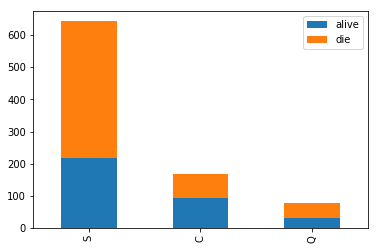

In [125]:
alive = df.Embarked[df.Survived == 1].value_counts()
die = df.Embarked[df.Survived == 0].value_counts()

_df = pd.DataFrame({'alive': alive, 'die': die})
_df.plot(kind='bar', stacked = True)
plt.show()

可以看到登陆港口和存活率还是有一定关联的，而且登陆港口数据存在部分缺失，我们应该要挖掘缺失的部分的影响

### Name 

因为男生女生的姓名一般不同，给一个姓名大多数情况下可以分辨出性别。虽然分出了性别，但是Miss和Mrs.都是female称呼不同可能年龄也不同，而年龄又存在部分缺失，因此我们需要将名字考虑在内。具体的处理在特征工程部分给出

In [126]:
df.Name.values

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

名字中都含有Mrs, Miss, Mr这些标识性别的关键词，其实也就是直接给出了性别，所以Name属性的价值可以认为归到了Sex上

### Age

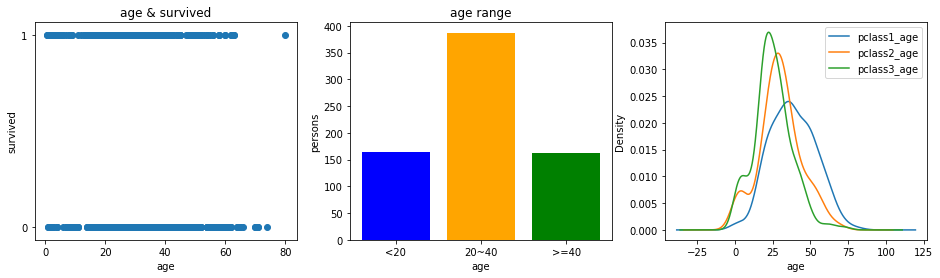

In [127]:
fig = plt.figure(figsize=(16, 4))

plt.subplot2grid((1, 3),(0, 0))
plt.title('age & survived')
plt.xlabel('age')
plt.ylabel('survived')
plt.yticks([0,1])
plt.scatter(df.Age, df.Survived)

# 各年龄分布
plt.subplot2grid((1, 3), (0, 1))
age_0_20 = len(df.Age[(df.Age.values >= 0) & (df.Age.values < 20)])
age_20_40 = len(df.Age[(df.Age.values >= 20) & (df.Age.values < 40)])
age_40_ = len(df.Age[(df.Age.values >= 40)])
age_list = (age_0_20,age_20_40,age_40_)
plt.title('age range')
plt.ylabel('persons')
plt.xlabel('age')
plt.xticks((0,1, 2),('<20','20~40', '>=40'))
plt.bar(left=(0,1,2),height=age_list, align='center', color=('blue', 'orange', 'green'))

# 各等级年龄分布
plt.subplot2grid((1, 3), (0, 2))
line1 = df.Age[df.Pclass==1].plot(kind='kde')
line2 = df.Age[df.Pclass==2].plot(kind='kde')
line3 = df.Age[df.Pclass==3].plot(kind='kde')
#_df = pd.DataFrame({'pclass1_age': line1, 'pclass2_age': line2, 'pclass3_age': line3})
#_df.plot(kind='kde')
plt.legend(('pclass1_age', 'pclass2_age', 'pclass3_age'))
plt.xlabel('age')

plt.show()

图1：可以看到的信息感觉不是很多，比较明显的是60～80之间存活率比较多，

图2：可以看到20~40年龄层占比最高，也就是中青年占比最高

图3：可以看到各等级舱位年龄占比。可以看到一等舱中年龄40岁左右的比较多，二等舱中30左右的比较多，三等舱20左右比较多，财富的配比也符合现实生活规律。

由此可以知道，年龄可以直接影响存活率（青中年各方面生理机能强，存活率高），也可以间接影响，因为年龄和所乘的舱位等级有一定的关联。

**之前的分析已经知道年龄存在缺失情况，如何减弱缺失部分的影响我们留到后面**

### Sex

俗话说“女士优先，男士靠边”，可想而知年龄应该也是一个影响因素，我们分析分析

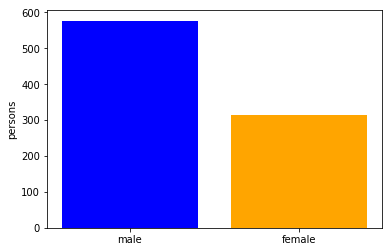

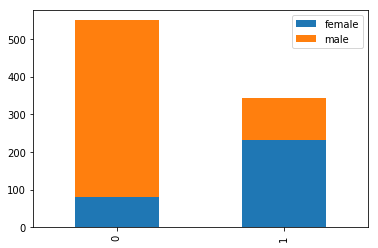

In [128]:
male = len(df.Sex[df.Sex == 'male'])
female = len(df.Sex[df.Sex == 'female'])
sex_list = (male, female)
plt.ylabel('persons')
plt.xticks((0, 1),('male','female'))
plt.bar(left=(0,1),height=sex_list, align='center', color=('blue', 'orange'))
plt.show()

male = df.Survived[df.Sex == 'male'].value_counts()
female = df.Survived[df.Sex == 'female'].value_counts()
_df = pd.DataFrame({'male': male, 'female': female})
_df.plot(kind='bar', stacked=True)
plt.show()

图1：男士比女士多

图2：存活中女士占多数，死亡中男士占多数

由1，2可以知道性别对存活率也有影响

### SibSp

船上乘客的兄弟姐妹/配偶数

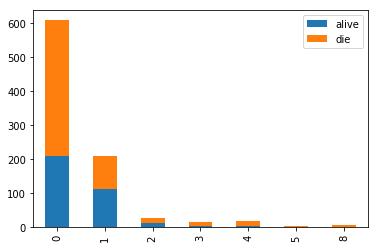

In [129]:
alive = df.SibSp[df.Survived == 1].value_counts()
die = df.SibSp[df.Survived == 0].value_counts()
_df = pd.DataFrame({'alive': alive, 'die': die})
_df.plot(kind='bar', stacked=True)
plt.show()

### Parch

船上乘客的父母/子女数

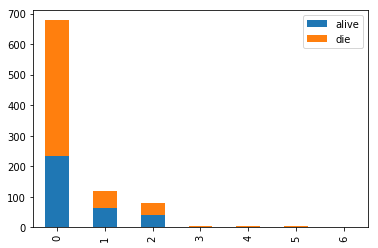

In [130]:
alive = df.Parch[df.Survived == 1].value_counts()
die = df.Parch[df.Survived == 0].value_counts()
_df = pd.DataFrame({'alive': alive, 'die': die})
_df.plot(kind='bar', stacked=True)
plt.show()

我们将SibSp和Parch结合在一起看看有没有规律

## 3. 特征工程 (feature engineering)

接下来要做的是对这些属性做特征工程，也是最需要脑洞和最关键的一步。

这一步我们主要处理：
* 将字符数据数值化   
   数值化一般两种方式
   以性别（gender）：男女， 为例解释
   * 连续值表示：即gender有两值，1代表男，0代表女表示性别
   * 二进制表示：需要新增字段gender_male, gender_female用0和1代表是否选择该值
   

* 对缺失值的处理
   对于缺值的情况，常见的处理方法：
   * 若缺值的样本占总数的比例极高，可以考虑舍弃。
   * 可以采用中位数，平均值，众数来填充缺失值
   * 如果缺值的样本适中，**离散型**特征属性（比如说类目属性）,那就把NaN作为一个新类别，加到类别特征中
   * 如果缺值的样本适中，**连续型**特征属性，可以考虑给定一个步长，目的是把它**离散化**，然后把NaN作为一个类型加到属性类目中
   * 回归预测出缺失值

In [131]:
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler()

train_df = df
test_df = pd.read_csv('./data/test.csv')
df = pd.concat([train_df, test_df])

# 从字符串中提取出数字串
def FindNumber(item):
    match = re.compile("([\d]+$)").search(item)
    if match:
        return match.group()
    else:
        return 0
    
# 获取字母
def getLetter(item):
    match = re.compile("([a-zA-Z]+)").search(item)
    if match:
        return match.group()
    else:
        return 'U'

### 对Cabin进行特征工程

In [132]:
df['Cabin'][df.Cabin.isnull()] = 'U0'
    
df['CabinLetter'] = df['Cabin'].map( lambda x : getLetter(x))
df['CabinLetter'] = pd.factorize(df['CabinLetter'])[0]
df['CabinNum'] = df['Cabin'].map( lambda x : FindNumber(x)).astype(int)
df['CabinNum'] = scaler.fit_transform(df['CabinNum'].reshape(-1 ,1))
#df['CabinNum']

### Ticket

将Ticket中的数字部分作为数值

In [133]:
#print(df.Ticket)
df['TicketNum'] = df.Ticket.map( lambda x : FindNumber(x)).astype(int)
df['TicketNum'] = scaler.fit_transform(df['TicketNum'].reshape(-1 ,1))
#print(df.TicketNum)

### Sex

1替换male, 0 替换female

In [134]:
df['Gender'] = np.where(df['Sex'] == 'male', 1, 0)
#df['Gender']

### Fare

选择中位数作为未知值的填充值

In [135]:
df['Fare'][ np.isnan(df['Fare']) ] = df['Fare'].median()
df['Fare'] = scaler.fit_transform(df['Fare'].reshape(-1 ,1))

### Embarked

对于登陆港口为空时，将其赋值为出现次数最多的港口,并将港口数值化

In [136]:
df.Embarked[df.Embarked.isnull()] = df.Embarked.dropna().mode().values
# 数值化
df['Embarked'] = pd.factorize(df['Embarked'])[0]
#df['Embarked']

### Pclass

对缺失值的处理和Embarked一样，用出现次数最多的值替代

In [137]:
df.Pclass[ df.Pclass.isnull() ] = df.Pclass.dropna().mode().values

df['Pclass'] = scaler.fit_transform(df['Pclass'].reshape(-1 ,1))

### Name

df['Appellation']  -  记录称呼，Mr, Mrs, Miss ... , 并数值化

In [138]:
df['Appellation'] = df['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

df['Appellation'][df.Appellation == 'Jonkheer'] = 'Master'
df['Appellation'][df.Appellation.isin(['Ms','Mlle'])] = 'Miss'
df['Appellation'][df.Appellation == 'Mme'] = 'Mrs'
df['Appellation'][df.Appellation.isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
df['Appellation'][df.Appellation.isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'

# 数值化
df['AppellationNum'] = pd.factorize(df['Appellation'])[0]

In [145]:
df['SibSp'] = scaler.fit_transform(df['SibSp'].reshape(-1 ,1))
df['Parch'] = scaler.fit_transform(df['Parch'].reshape(-1 ,1))

### Age

Age 由之前的分析可知是一个重要影响因素，很多属性可以影响到年龄，所以在这里我们用**回归去预测缺失的年龄。**

In [140]:
age_df = df[['Age', 'Embarked','Fare', 'Parch', 'SibSp', 'AppellationNum','Pclass', 'CabinLetter', 'CabinNum']]
X = age_df.loc[(df.Age.notnull())].values[:, 1::]
y = age_df.loc[(df.Age.notnull())].values[:, 0]

rgr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
rgr.fit(X, y)

preds = rgr.predict(age_df.loc[ (df.Age.isnull()) ].values[:, 1::])
df.loc[ (df.Age.isnull()), 'Age' ] = preds
df['Age'] = scaler.fit_transform(df['Age'].reshape(-1 ,1))

In [141]:
df_choosed = df[['Survived', 'Age', 'Fare', 'Parch', 'Pclass', 'SibSp', 'TicketNum', 'CabinLetter', 'CabinNum', 'Gender', 'AppellationNum']]

train_df = df_choosed[:train_df.shape[0]] 
test_df  = df_choosed[train_df.shape[0]:]

## 4. 模型

这类数据我们一般使用集成的方法作为分类器，随机森林,GDBT, XGBoost会有较好的效果，为了找到最佳参数我们使用网格搜索来寻找最佳参数

In [142]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

train_data = train_df.as_matrix()
test_data = test_df.as_matrix()

X_train, y_train = train_data[:, 1::], train_data[:, 0]
X_test, y_test = test_data[:, 1::], test_data[:, 0]

clf = RandomForestClassifier(n_jobs=-1, oob_score=True)

params = { 
    "n_estimators" : [200, 500, 1000, 2000, 5000, 10000],
    "max_features" : [3, 4, 5], 
    "min_samples_split" : [4, 6, 8, 10]
}
gs= GridSearchCV(clf, params)
gs.fit(X_train, y_train)
print('Done !')

Done !


In [143]:
train_score = gs.score(X_train, y_train)
print('train accuracy: ', train_score)

train accuracy:  0.930415263749


In [144]:
y_pred = gs.predict(X_test)

passengerId = df['PassengerId'][train_df.shape[0]:]

# out to file
result = pd.DataFrame({'PassengerId': passengerId.as_matrix(), 'Survived':y_pred.astype(np.int32)})
result.to_csv("./result.csv", index=False)
result

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


## 结果

上述baseline提交到kaggle后准确率为0.78468可以排4023名，分析结果可以知道模型存在了过拟合，接下来我们要做的就是对baseline进行参数进行反复调整。**"No Free Lunch"**定理告诉我们没有一个模型是包打天下的，反复调参甚至更换模型是关键！